---
## Evaluating Model Performance
We'll investigate several different algorithms and determine which is best at modeling the data.

### Implementation - Creating a Training and Predicting Pipeline

To properly evaluate the performance of various models, we need to create a training and predicting pipeline that allows for quick and effective model training using various sizes of training data and perform predictions on the testing data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline

from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

sns.set()

In [2]:
df = pd.read_csv('../data/processed/features_final.csv', index_col='Id')
target = pd.read_csv('../data/interim/target_log_xformed.csv', index_col='Id', squeeze=True)

test_df = pd.read_csv('../data/processed/test_final.csv', index_col='Id')

df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
Id,,,,,,,,,,,,,,,,,,,,,
1,0.072871,-0.085934,-0.127336,0.666823,-0.517687,1.054053,0.880646,1.195901,0.783893,-0.35603,...,-0.045455,0.388726,0.0,-0.271663,-0.052504,-0.091192,-0.118056,0.465355,-0.303879,0.0
2,-0.871698,0.530639,0.121231,-0.063770,2.175642,0.159914,-0.426795,-0.815143,0.892788,-0.35603,...,-0.045455,0.388726,0.0,-0.271663,-0.052504,-0.091192,-0.118056,0.465355,-0.303879,0.0
3,0.072871,0.047896,0.430208,0.666823,-0.517687,0.987820,0.832223,1.123786,0.659186,-0.35603,...,-0.045455,0.388726,0.0,-0.271663,-0.052504,-0.091192,-0.118056,0.465355,-0.303879,0.0
4,0.309014,-0.323119,0.111058,0.666823,-0.517687,-1.860177,-0.717337,-0.815143,0.388751,-0.35603,...,-0.045455,0.388726,0.0,3.681032,-0.052504,-0.091192,-0.118056,-2.148898,-0.303879,0.0
5,0.072871,0.675761,0.892091,1.397416,-0.517687,0.954704,0.735375,1.415757,0.758846,-0.35603,...,-0.045455,0.388726,0.0,-0.271663,-0.052504,-0.091192,-0.118056,0.465355,-0.303879,0.0


In [3]:
target.head()

Id
1    12.247694
2    12.109011
3    12.317167
4    11.849398
5    12.429216
Name: SalePrice, dtype: float64

In [4]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(df, 
                                                    target, 
                                                    test_size = 0.2,
                                                    random_state = 5)

# Show the results of the split
print(f'Training set has {X_train.shape[0]} samples.')
print(f'Testing set has {X_val.shape[0]} samples.')

Training set has 1164 samples.
Testing set has 291 samples.


In [5]:
# def evaluate(results, mae):

def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - results: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - mae: Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (16,12))

    # Constants
    bar_width = 0.08
#     colors = ['#A00000','#00A0A0','#00A000']
    colors = sns.color_palette()
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'rmse_train', 'mae_train', 'pred_time', 'rmse_test', 'mae_test']):
            for i in range(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Root Mean Squared Error")
    ax[0, 2].set_ylabel("Mean Absolute Error")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Root Mean Squared Error")
    ax[1, 2].set_ylabel("Mean Absolute Error")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("RMSE - Training Subset")
    ax[0, 2].set_title("MAE - Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("RMSE - Testing Set")
    ax[1, 2].set_title("MAE - Testing Subset")

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, loc='upper center', bbox_to_anchor=(-.8, 2.53), ncol = 4, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.0)
    plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features testing set
       - y_val: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the validation set(X_val) then training set
    start = time() # Get start time
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    # Compute RMSE on the training set
    results['rmse_train'] = mean_squared_error(np.exp(y_train), np.exp(predictions_train), squared=False)
    
    # Compute RMSE on test set
    results['rmse_test'] = mean_squared_error(np.exp(y_val), np.exp(predictions_val), squared=False)
    
    # Compute MAE on the the training set
    results['mae_train'] = mean_absolute_error(np.exp(y_train), np.exp(predictions_train))
        
    # Compute MAE on the validation set
    results['mae_test'] = mean_absolute_error(np.exp(y_val), np.exp(predictions_val))
       
    # Success
    print(f'{learner.__class__.__name__} trained on {sample_size} samples.')
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

In [7]:
# Import supervised learning models

from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor

# Initialize the models

tr_model = TweedieRegressor(power=2, link='log')
rf_model = RandomForestRegressor(random_state=5)
adaBoost_model = AdaBoostRegressor(random_state=5)
gb_model = GradientBoostingRegressor(random_state=5)
ridge_model = Ridge(random_state=5)
knn_model = KNeighborsRegressor()

algorithms = [tr_model, rf_model, adaBoost_model, gb_model,
              ridge_model, knn_model]

TweedieRegressor trained on 11 samples.
TweedieRegressor trained on 116 samples.
TweedieRegressor trained on 1164 samples.
RandomForestRegressor trained on 11 samples.
RandomForestRegressor trained on 116 samples.
RandomForestRegressor trained on 1164 samples.
AdaBoostRegressor trained on 11 samples.
AdaBoostRegressor trained on 116 samples.
AdaBoostRegressor trained on 1164 samples.
GradientBoostingRegressor trained on 11 samples.
GradientBoostingRegressor trained on 116 samples.
GradientBoostingRegressor trained on 1164 samples.
Ridge trained on 11 samples.
Ridge trained on 116 samples.
Ridge trained on 1164 samples.
KNeighborsRegressor trained on 11 samples.
KNeighborsRegressor trained on 116 samples.
KNeighborsRegressor trained on 1164 samples.


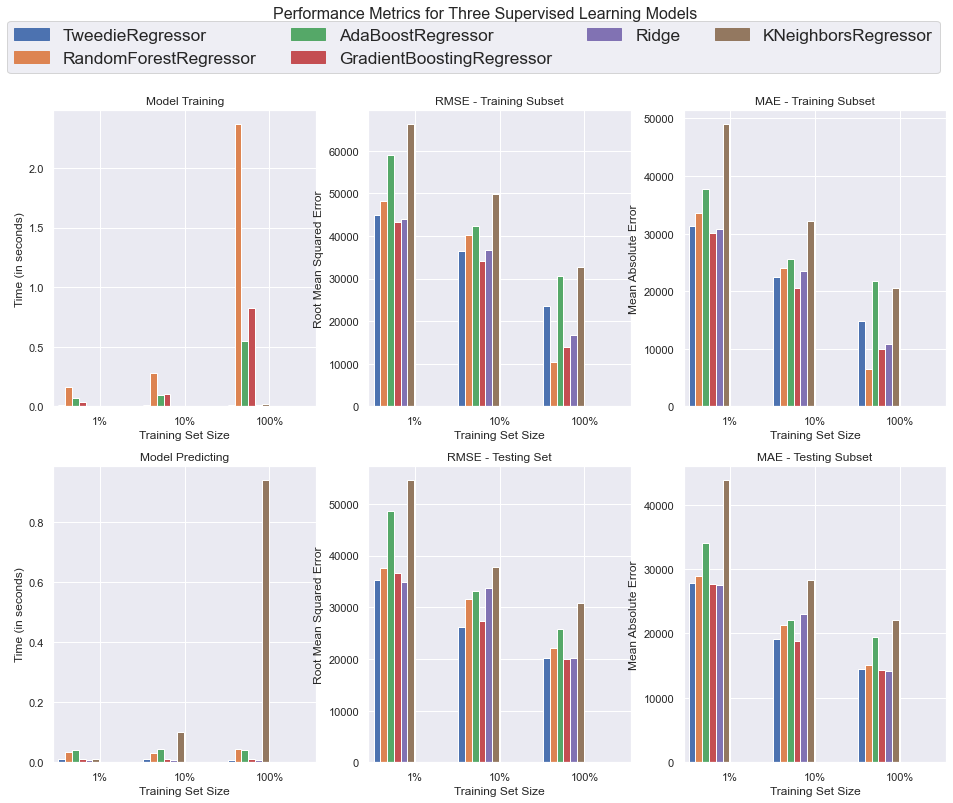

In [8]:
# Algorithm Comparison

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100
# samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = np.int_((samples_100 * 0.1))
samples_1 = np.int_((samples_100 * 0.01))

# Collect results on the learners
results = {}
# for rgsr in [rgsr_A, rgsr_B, rgsr_C, rgsr_D]:
for rgsr in algorithms:
    rgsr_name = rgsr.__class__.__name__
    results[rgsr_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[rgsr_name][i] = \
        train_predict(rgsr, samples, X_train, y_train, X_val, y_val)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Model_Comparison_Performance_Metrics.svg')

In [9]:
results

{'TweedieRegressor': {0: {'train_time': 0.010012149810791016,
   'pred_time': 0.009263992309570312,
   'rmse_train': 44880.48386908598,
   'rmse_test': 35212.47597961001,
   'mae_train': 31243.84395692866,
   'mae_test': 27763.41331468564},
  1: {'train_time': 0.01438283920288086,
   'pred_time': 0.010256290435791016,
   'rmse_train': 36344.46565013625,
   'rmse_test': 26220.01275335401,
   'mae_train': 22468.490676957575,
   'mae_test': 19081.076439360386},
  2: {'train_time': 0.011838912963867188,
   'pred_time': 0.0082550048828125,
   'rmse_train': 23648.887072626403,
   'rmse_test': 20225.198013127814,
   'mae_train': 14844.522317799116,
   'mae_test': 14527.021174319561}},
 'RandomForestRegressor': {0: {'train_time': 0.15983009338378906,
   'pred_time': 0.033524274826049805,
   'rmse_train': 48267.14966628034,
   'rmse_test': 37616.424796858606,
   'mae_train': 33504.59073119604,
   'mae_test': 28936.285519969922},
  1: {'train_time': 0.2815120220184326,
   'pred_time': 0.03215289

### Choosing the best model

The GradientBoostRegressor Algorithm appears to return the lowest RMSE for our testing set. We'll try tuning it's parameters/hyperparameters to see if we can further improve our predictions

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the regressor
rgsr = GradientBoostingRegressor(random_state=5)

# Create the parameters list to tune
parameters = {'n_estimators': [10, 100, 1000], 'learning_rate': [0.001, 0.01, 0.1]}

# Make an RMSE scoring object using make_scorer()
scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=rgsr, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_rgsr = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (rgsr.fit(X_train, y_train)).predict(X_val)
best_predictions = best_rgsr.predict(X_val)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("RMSE on testing data: {:.4f}".format(mean_squared_error(np.exp(y_val), np.exp(predictions), squared=False)))
print("\nOptimized Model\n------")
print("Final RMSE on the testing data: {:.4f}".format(mean_squared_error(np.exp(y_val), np.exp(best_predictions), squared=False)))

Unoptimized model
------
RMSE on testing data: 19933.2468

Optimized Model
------
Final RMSE on the testing data: 18507.3550


In [11]:
best_rgsr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 5,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [12]:
final_preds = best_rgsr.predict(test_df)

In [13]:
preds = pd.Series(np.exp(final_preds), index=test_df.index, name='SalePrice')

# Uncomment this line to export Results
# preds.to_csv('../data/processed/predictions.csv')